PRÉ PROCESSAMENTO, BALANCEAMENTO E SALVAMENTO DA SAMPLE:

In [2]:
import pandas as pd
import numpy as np

files = [
    "Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv",
    "Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv",
]

# -----------------------------
# Colunas relevantes
# -----------------------------
cols_to_keep = [
    'Label', 'Protocol', 'Src Port', 'Dst Port',
    'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
    'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean',
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
    'FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt',
    'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt'
]

chunk_size = 200000
dfs = []

# -----------------------------
# Ler em chunks e acumular
# -----------------------------
for file in files:
    for chunk in pd.read_csv(file, chunksize=chunk_size, low_memory=False):
        chunk.columns = [c.strip() for c in chunk.columns]
        cols_existentes = [c for c in cols_to_keep if c in chunk.columns]
        chunk = chunk[cols_existentes]
        chunk['Label'] = chunk['Label'].astype(str).str.strip()
        chunk = chunk[chunk['Label'] != 'nan']
        dfs.append(chunk)

# Concatenar todos os chunks
df = pd.concat(dfs, ignore_index=True)
del dfs
print("Shape após concatenação:", df.shape)

# -----------------------------
# Converter colunas numéricas
# -----------------------------
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# -----------------------------
# Transformar Label em binária (0 = benigno, 1 = ataque)
# -----------------------------
df['Label'] = np.where(df['Label'].str.lower() == 'benign', 0, 1)

# -----------------------------
# Remover linhas com Label ausente
# -----------------------------
df = df.dropna(subset=['Label'])
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# -----------------------------
# Preencher NaN nas colunas numéricas com a mediana
# -----------------------------
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# -----------------------------
# Remover features altamente correlacionadas
# -----------------------------
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'Label']
corr_matrix = df[num_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
if to_drop:
    print(f"Colunas com correlação > {threshold} que serão removidas ({len(to_drop)}):")
    print(to_drop)
    df = df.drop(columns=to_drop)
else:
    print("Nenhuma coluna altamente correlacionada encontrada acima do threshold.")

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'Label']

# -----------------------------
# Checagem rápida
# -----------------------------
counts = df['Label'].value_counts()
print("Contagem após limpeza (0=benign,1=attack):")
print(counts)

# -----------------------------
# Criar amostra balanceada (600.000 linhas)
# -----------------------------
n_total = 600000
n_benign = int(n_total * 0.9)
n_ddos = n_total - n_benign

if counts.get(0, 0) < n_benign or counts.get(1, 0) < n_ddos:
    raise ValueError(
        f"Não há exemplos suficientes: benignos={counts.get(0,0)}, ataques={counts.get(1,0)}. "
        "Ajuste n_total ou revise os arquivos lidos."
    )

df_benign = df[df['Label'] == 0].sample(n=n_benign, random_state=42)
df_ddos = df[df['Label'] == 1].sample(n=n_ddos, random_state=42)

df_sample = pd.concat([df_benign, df_ddos], ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42)  # embaralhar

# -----------------------------
# Remover duplicatas do df_sample
# -----------------------------
df_sample = df_sample.drop_duplicates().reset_index(drop=True)
print("Shape da amostra final, após remoção de duplicatas:", df_sample.shape)
print("Distribuição da coluna Label (0 = benigno, 1 = ataque):")
print(df_sample['Label'].value_counts())

# -----------------------------
# Salvar a amostra final
# -----------------------------
df_sample.to_csv("df_sample.csv", index=False)
print("Arquivo df_sample.csv salvo com sucesso!")

Shape após concatenação: (8997323, 21)
Colunas com correlação > 0.95 que serão removidas (2):
['TotLen Fwd Pkts', 'TotLen Bwd Pkts']
Contagem após limpeza (0=benign,1=attack):
Label
0    7733390
1    1263933
Name: count, dtype: int64
Shape da amostra final, após remoção de duplicatas: (584227, 19)
Distribuição da coluna Label (0 = benigno, 1 = ataque):
Label
0    535925
1     48302
Name: count, dtype: int64
Arquivo df_sample.csv salvo com sucesso!


Análise exploratória da Sample

ANÁLISE EXPLORATÓRIA - DF_SAMPLE.CSV

1. INFORMAÇÕES GERAIS DO DATASET

Shape do dataset: (584227, 19)
Linhas: 584,227
Colunas: 19

Colunas presentes:
   1. Label
   2. Protocol
   3. Src Port
   4. Dst Port
   5. Flow Duration
   6. Tot Fwd Pkts
   7. Tot Bwd Pkts
   8. Fwd Pkt Len Max
   9. Fwd Pkt Len Min
  10. Fwd Pkt Len Mean
  11. Bwd Pkt Len Max
  12. Bwd Pkt Len Min
  13. Bwd Pkt Len Mean
  14. FIN Flag Cnt
  15. SYN Flag Cnt
  16. PSH Flag Cnt
  17. ACK Flag Cnt
  18. URG Flag Cnt
  19. ECE Flag Cnt

Tipos de dados:
int64      12
float64     7
Name: count, dtype: int64

Memória utilizada: 84.69 MB

Duplicatas: 0 (0.00%)
Valores ausentes (total): 0

2. DISTRIBUIÇÃO DE CLASSES (LABEL)

Total de classes: 2
  Label 0 (Benigno):  535,925 (91.73%)
  Label 1 (Ataque):   48,302 ( 8.27%)


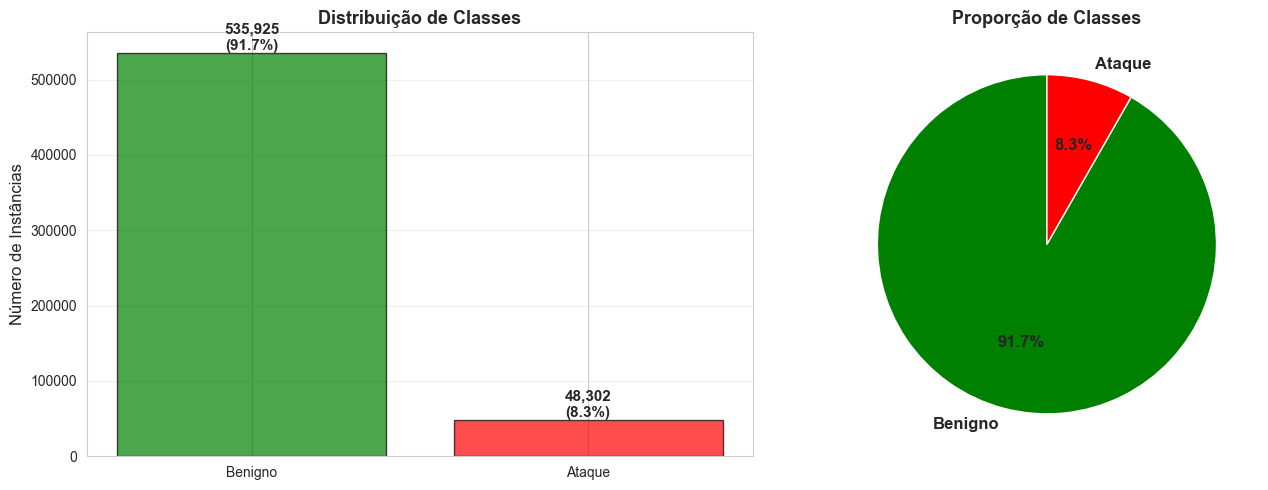


3. ANÁLISE DE PROTOCOLOS

Protocolos únicos: 3

Distribuição por Protocolo:
    0 - HOPOPT/Unknown       |      8,885 ( 1.52%)
    6 - TCP                  |    400,635 (68.58%)
   17 - UDP                  |    174,707 (29.90%)

Distribuição de Protocolos por Classe:
Label          0      1
Protocol               
0           8885      0
6         352456  48179
17        174584    123


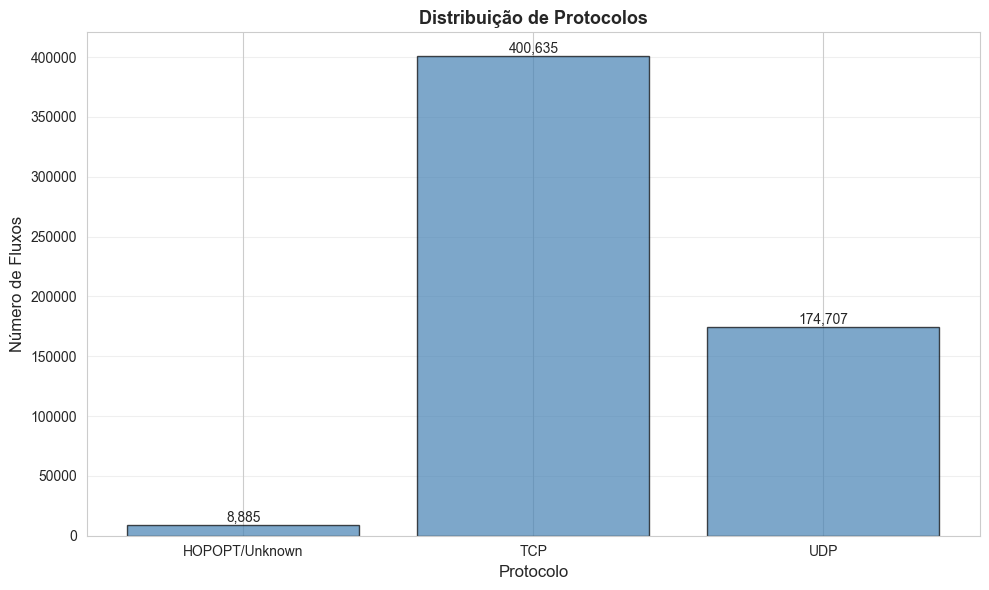


4. ANÁLISE DE PORTAS (SRC E DST)

--- Top 20 Portas de Origem (Src Port) ---
 1. Porta 52413              |   46,236 ( 7.91%)
 2. Porta   443 HTTPS        |   42,045 ( 7.20%)
 3. Porta   445 SMB          |   14,807 ( 2.53%)
 4. Porta    80 HTTP         |   10,564 ( 1.81%)
 5. Porta     0              |    8,880 ( 1.52%)
 6. Porta  3389 RDP          |    5,578 ( 0.95%)
 7. Porta 49672              |    1,460 ( 0.25%)
 8. Porta 49673              |      711 ( 0.12%)
 9. Porta   123              |      659 ( 0.11%)
10. Porta    68              |      354 ( 0.06%)
11. Porta 49674              |      338 ( 0.06%)
12. Porta   137              |      303 ( 0.05%)
13. Porta 49682              |      184 ( 0.03%)
14. Porta 49688              |      157 ( 0.03%)
15. Porta   138              |      155 ( 0.03%)
16. Porta 49687              |      147 ( 0.03%)
17. Porta 49675              |      136 ( 0.02%)
18. Porta 49691              |      135 ( 0.02%)
19. Porta 49679              |      130 

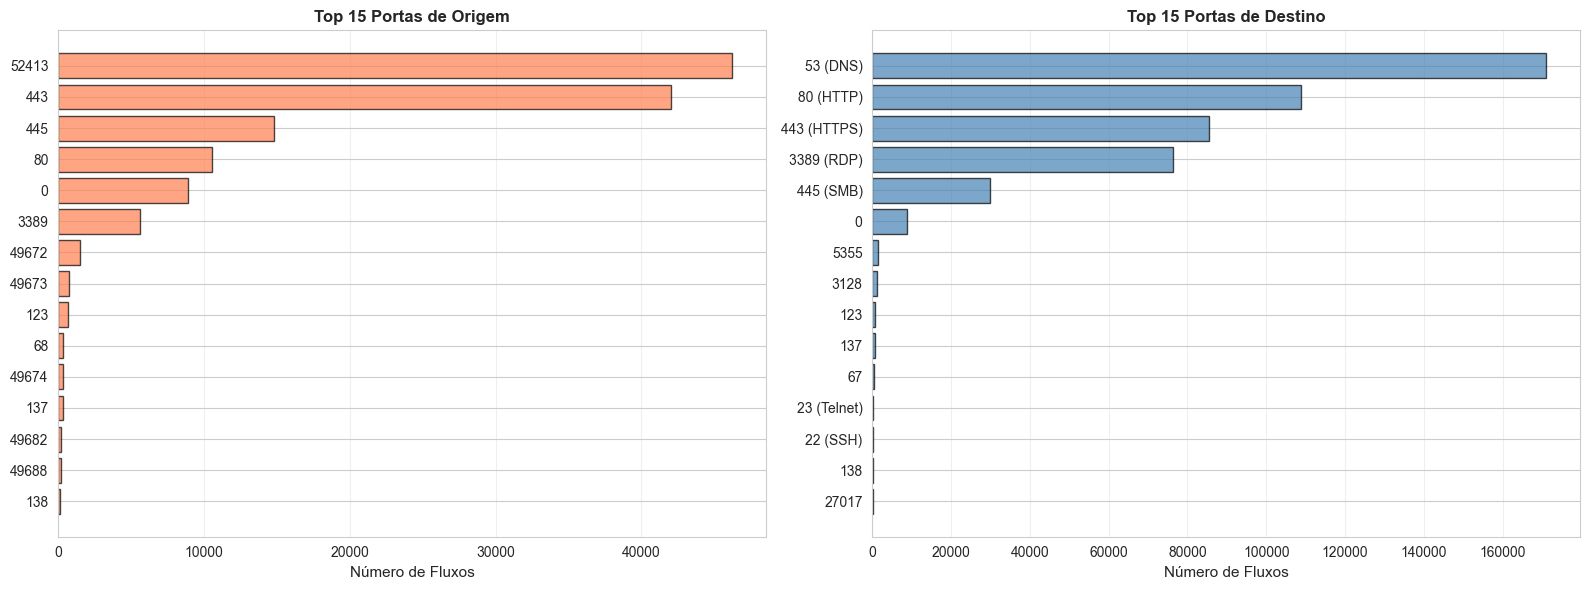


5. ANÁLISE DE FLAGS TCP

Estatísticas de Flags TCP:
Flag            |        Total |      Média |      Fluxos > 0 |   % Fluxos
--------------------------------------------------------------------------------
FIN             |        3,202 |       0.01 |           3,202 |      0.55%
SYN             |       31,431 |       0.05 |          31,431 |      5.38%
PSH             |      243,611 |       0.42 |         243,611 |     41.70%
ACK             |      154,883 |       0.27 |         154,883 |     26.51%
URG             |       20,830 |       0.04 |          20,830 |      3.57%
ECE             |      144,312 |       0.25 |         144,312 |     24.70%

Flags TCP por Classe (Média):
       FIN Flag Cnt  SYN Flag Cnt  PSH Flag Cnt  ACK Flag Cnt  URG Flag Cnt  \
Label                                                                         
0          0.005975      0.058648      0.414636      0.239028      0.038867   
1          0.000000      0.000000      0.442984      0.554470      0.0000

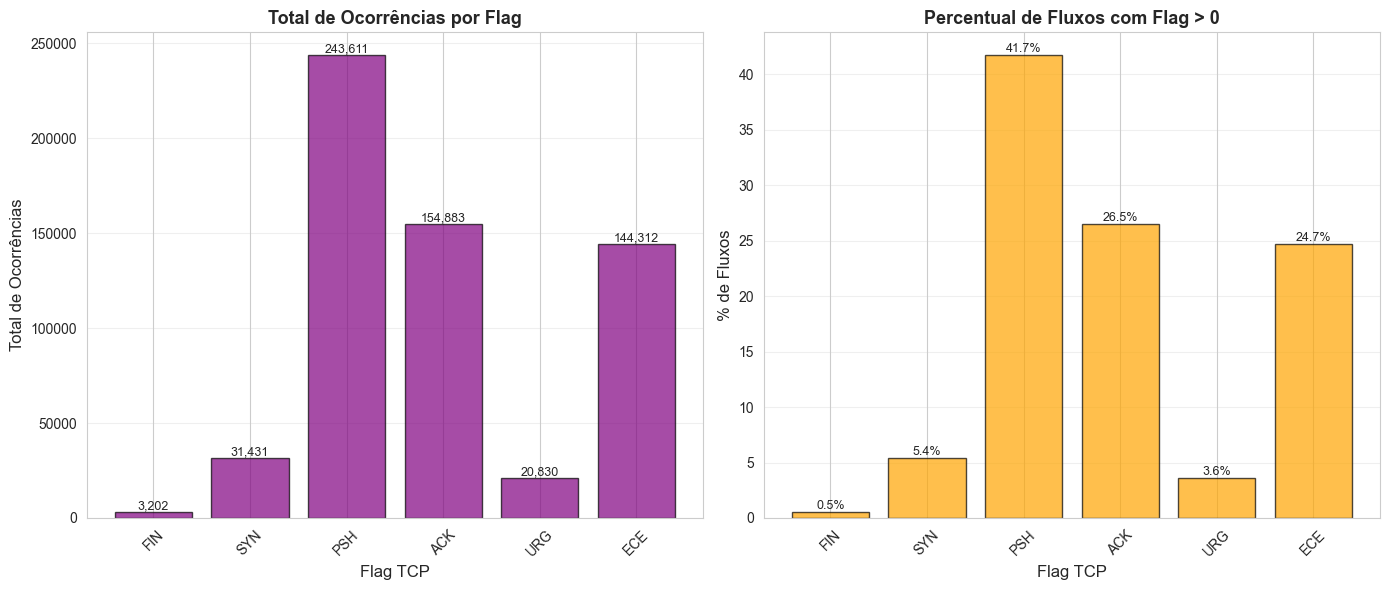


6. ESTATÍSTICAS DESCRITIVAS DAS FEATURES NUMÉRICAS

Estatísticas Descritivas:
                     count          mean           std  min         25%  \
Flow Duration     584227.0  1.244597e+07  3.150909e+07  0.0  577.000000   
Tot Fwd Pkts      584227.0  2.946729e+01  1.721715e+03  1.0    1.000000   
Tot Bwd Pkts      584227.0  6.258709e+00  1.337961e+02  0.0    1.000000   
Fwd Pkt Len Max   584227.0  2.064210e+02  2.973239e+02  0.0   20.000000   
Fwd Pkt Len Min   584227.0  1.254785e+01  2.381840e+01  0.0    0.000000   
Fwd Pkt Len Mean  584227.0  5.263133e+01  5.729574e+01  0.0    6.666667   
Bwd Pkt Len Max   584227.0  3.868418e+02  5.133569e+02  0.0    0.000000   
Bwd Pkt Len Min   584227.0  3.070686e+01  5.308741e+01  0.0    0.000000   
Bwd Pkt Len Mean  584227.0  1.256903e+02  1.646839e+02  0.0    0.000000   

                      50%           75%           max  
Flow Duration     20758.0  2.501499e+06  1.200000e+08  
Tot Fwd Pkts          2.0  6.000000e+00  2.427600e+05  
To

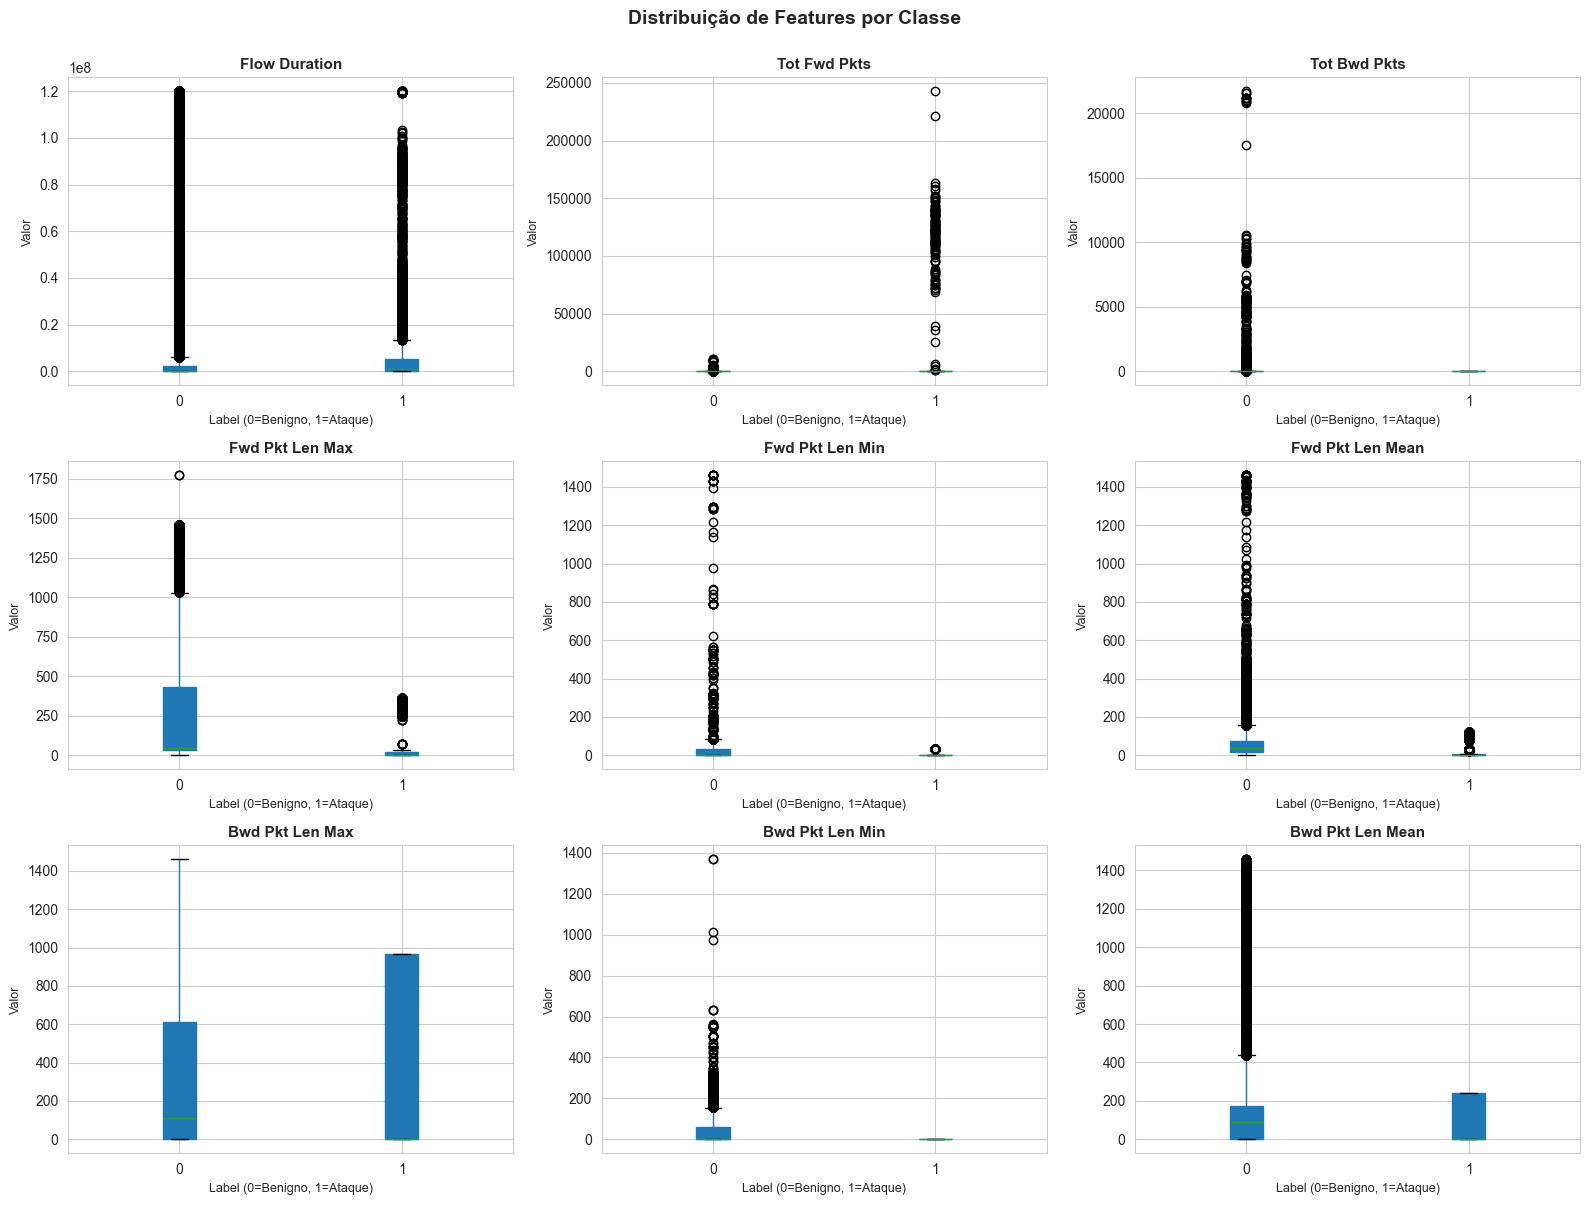


7. CORRELAÇÃO ENTRE FEATURES


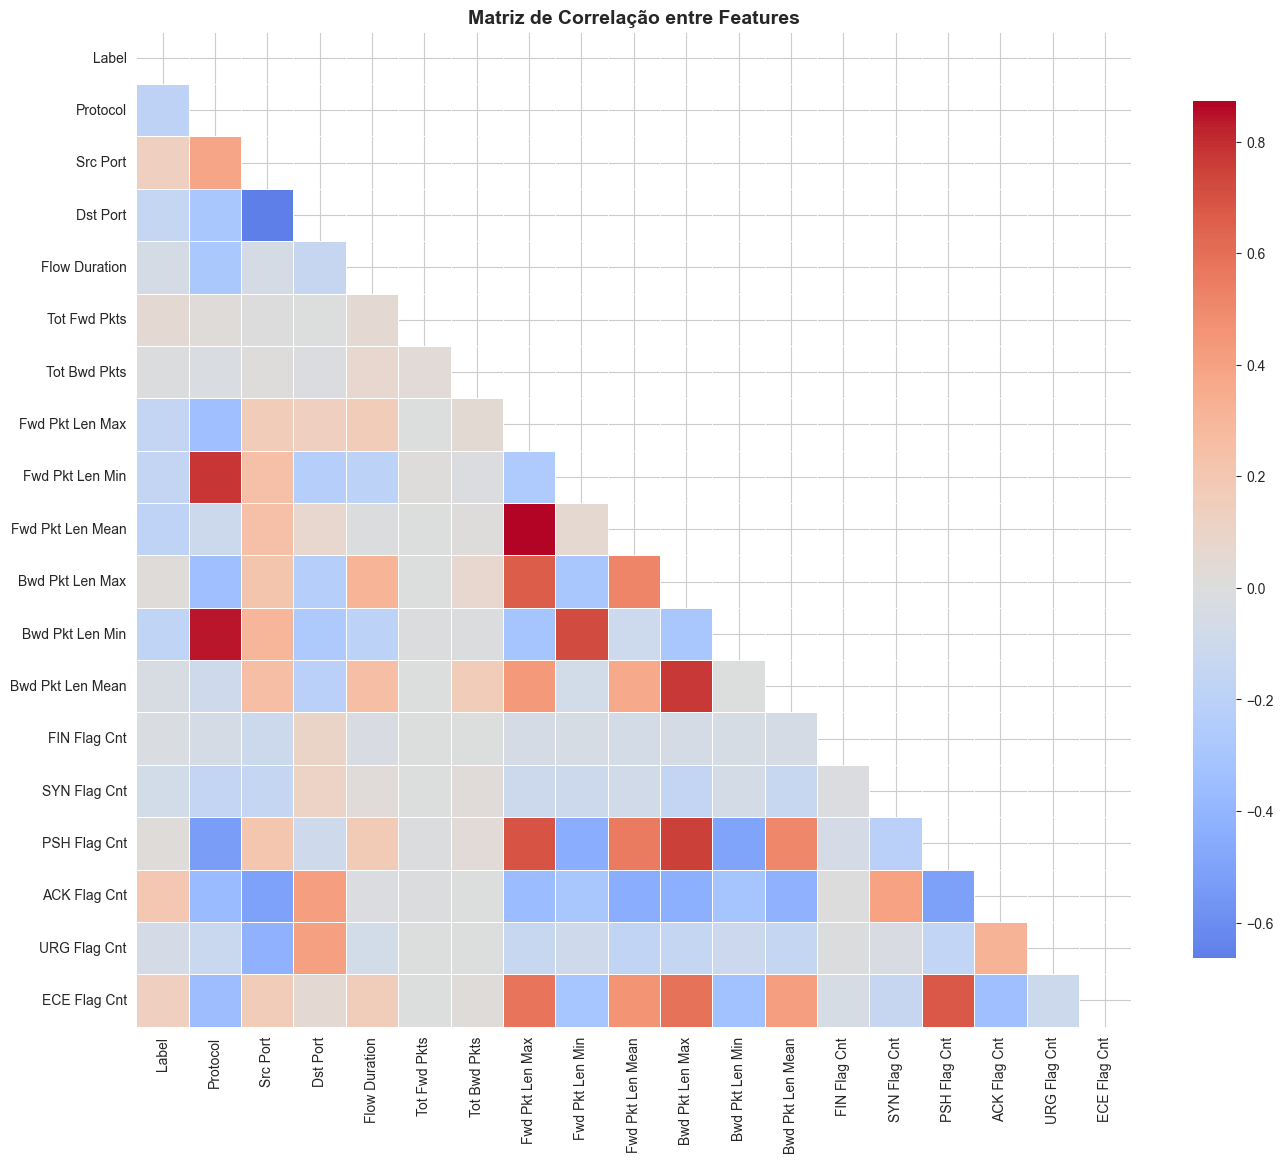


8. RESUMO

DIMENSÕES:
   - Total de instâncias: 584,227
   - Total de features: 19
   - Memória: 84.69 MB

DISTRIBUIÇÃO DE CLASSES:
   - Benignos (Label 0): 535,925 (91.73%)
   - Ataques (Label 1): 48,302 (8.27%)
   - Razão Benigno/Ataque: 11.10:1

PROTOCOLOS:
   - Protocolos únicos: 3
   - Protocolo dominante: HOPOPT/Unknown (1.52%)

PORTAS:
   - Dst Port mais comum: 53 (29.29%)
   - Src Port mais comum: 52413 (7.91%)

FLAGS TCP:
   - Flag mais frequente: PSH
   - Total de flags setadas: 598,269

FEATURES NUMÉRICAS:
   - Flow Duration médio: 12445972.93 µs
   - Total Fwd Pkts médio: 29.47
   - Total Bwd Pkts médio: 6.26

QUALIDADE DOS DADOS:
   - Duplicatas: 0 (0.00%)
   - Valores ausentes: 0

ANÁLISE EXPLORATÓRIA CONCLUÍDA!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("ANÁLISE EXPLORATÓRIA - DF_SAMPLE.CSV")
print("=" * 80)

# -----------------------------
# 1. CARREGAR DATASET
# -----------------------------
df = pd.read_csv('df_sample.csv')

print("\n" + "=" * 80)
print("1. INFORMAÇÕES GERAIS DO DATASET")
print("=" * 80)

print(f"\nShape do dataset: {df.shape}")
print(f"Linhas: {len(df):,}")
print(f"Colunas: {len(df.columns)}")

print(f"\nColunas presentes:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nTipos de dados:")
print(df.dtypes.value_counts())

print(f"\nMemória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar duplicatas
duplicatas = df.duplicated().sum()
print(f"\nDuplicatas: {duplicatas:,} ({100*duplicatas/len(df):.2f}%)")

# Valores ausentes
missing = df.isnull().sum().sum()
print(f"Valores ausentes (total): {missing:,}")

# -----------------------------
# 2. DISTRIBUIÇÃO DE CLASSES
# -----------------------------
print("\n" + "=" * 80)
print("2. DISTRIBUIÇÃO DE CLASSES (LABEL)")
print("=" * 80)

label_counts = df['Label'].value_counts().sort_index()
print(f"\nTotal de classes: {len(label_counts)}")

for label, count in label_counts.items():
    label_name = "Benigno" if label == 0 else "Ataque"
    percentage = 100 * count / len(df)
    print(f"  Label {label} ({label_name}): {count:>8,} ({percentage:>5.2f}%)")

# Gráfico de distribuição
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = ['green', 'red']
labels_names = ['Benigno', 'Ataque']
ax1.bar(labels_names, label_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Número de Instâncias', fontsize=12)
ax1.set_title('Distribuição de Classes', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(label_counts.values):
    ax1.text(i, v, f'{v:,}\n({100*v/len(df):.1f}%)', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gráfico de pizza
ax2.pie(label_counts.values, labels=labels_names, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Proporção de Classes', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# -----------------------------
# 3. ANÁLISE DE PROTOCOLOS
# -----------------------------
print("\n" + "=" * 80)
print("3. ANÁLISE DE PROTOCOLOS")
print("=" * 80)

protocol_counts = df['Protocol'].value_counts().sort_index()

protocol_map = {
    0: 'HOPOPT/Unknown',
    1: 'ICMP',
    6: 'TCP',
    17: 'UDP',
    41: 'IPv6'
}

print(f"\nProtocolos únicos: {len(protocol_counts)}")
print(f"\nDistribuição por Protocolo:")

for proto_num, count in protocol_counts.items():
    proto_name = protocol_map.get(int(proto_num), f'Unknown ({int(proto_num)})')
    percentage = 100 * count / len(df)
    print(f"  {int(proto_num):3d} - {proto_name:20s} | {count:>10,} ({percentage:>5.2f}%)")

# Distribuição por protocolo e classe
print(f"\nDistribuição de Protocolos por Classe:")
proto_label = df.groupby(['Protocol', 'Label']).size().unstack(fill_value=0)
print(proto_label)

# Gráfico de protocolos
plt.figure(figsize=(10, 6))
proto_labels = [protocol_map.get(int(p), f'Proto {int(p)}') for p in protocol_counts.index]
plt.bar(proto_labels, protocol_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
plt.ylabel('Número de Fluxos', fontsize=12)
plt.xlabel('Protocolo', fontsize=12)
plt.title('Distribuição de Protocolos', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(protocol_counts.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. ANÁLISE DE PORTAS
# -----------------------------
print("\n" + "=" * 80)
print("4. ANÁLISE DE PORTAS (SRC E DST)")
print("=" * 80)

well_known_ports = {
    20: 'FTP-Data', 21: 'FTP', 22: 'SSH', 23: 'Telnet',
    25: 'SMTP', 53: 'DNS', 80: 'HTTP', 110: 'POP3',
    143: 'IMAP', 443: 'HTTPS', 445: 'SMB', 3306: 'MySQL',
    3389: 'RDP', 5432: 'PostgreSQL', 8080: 'HTTP-Alt'
}

print("\n--- Top 20 Portas de Origem (Src Port) ---")
src_port_counts = df['Src Port'].value_counts().head(20)
for i, (port, count) in enumerate(src_port_counts.items(), 1):
    port_int = int(port)
    port_name = well_known_ports.get(port_int, '')
    percentage = 100 * count / len(df)
    print(f"{i:2d}. Porta {port_int:5d} {port_name:12s} | {count:>8,} ({percentage:>5.2f}%)")

print("\n--- Top 20 Portas de Destino (Dst Port) ---")
dst_port_counts = df['Dst Port'].value_counts().head(20)
for i, (port, count) in enumerate(dst_port_counts.items(), 1):
    port_int = int(port)
    port_name = well_known_ports.get(port_int, '')
    percentage = 100 * count / len(df)
    print(f"{i:2d}. Porta {port_int:5d} {port_name:12s} | {count:>8,} ({percentage:>5.2f}%)")

# Gráfico de portas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 Src Ports
top_src = src_port_counts.head(15)
ax1.barh(range(len(top_src)), top_src.values, color='coral', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(top_src)))
src_labels = [f'{int(p)}' for p in top_src.index]
ax1.set_yticklabels(src_labels)
ax1.set_xlabel('Número de Fluxos', fontsize=11)
ax1.set_title('Top 15 Portas de Origem', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Top 15 Dst Ports
top_dst = dst_port_counts.head(15)
ax2.barh(range(len(top_dst)), top_dst.values, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(top_dst)))
dst_labels = []
for p in top_dst.index:
    port_int = int(p)
    name = well_known_ports.get(port_int, '')
    dst_labels.append(f'{port_int} ({name})' if name else f'{port_int}')
ax2.set_yticklabels(dst_labels)
ax2.set_xlabel('Número de Fluxos', fontsize=11)
ax2.set_title('Top 15 Portas de Destino', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# 5. ANÁLISE DE FLAGS TCP
# -----------------------------
print("\n" + "=" * 80)
print("5. ANÁLISE DE FLAGS TCP")
print("=" * 80)

tcp_flags = ['FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt', 
             'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt']

print(f"\nEstatísticas de Flags TCP:")
print(f"{'Flag':15s} | {'Total':>12s} | {'Média':>10s} | {'Fluxos > 0':>15s} | {'% Fluxos':>10s}")
print("-" * 80)

flag_data = {}
for flag in tcp_flags:
    if flag in df.columns:
        total = df[flag].sum()
        mean = df[flag].mean()
        non_zero = (df[flag] > 0).sum()
        pct_non_zero = 100 * non_zero / len(df)
        flag_name = flag.replace(' Flag Cnt', '')
        print(f"{flag_name:15s} | {int(total):>12,} | {mean:>10.2f} | {non_zero:>15,} | {pct_non_zero:>9.2f}%")
        flag_data[flag_name] = {'total': total, 'mean': mean, 'non_zero': non_zero}

# Comparar flags entre benignos e ataques
print(f"\nFlags TCP por Classe (Média):")
print(df.groupby('Label')[tcp_flags].mean())

# Gráfico das flags
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Total de ocorrências
flag_names = list(flag_data.keys())
flag_totals = [flag_data[f]['total'] for f in flag_names]
ax1.bar(flag_names, flag_totals, color='purple', alpha=0.7, edgecolor='black')
ax1.set_ylabel('Total de Ocorrências', fontsize=12)
ax1.set_xlabel('Flag TCP', fontsize=12)
ax1.set_title('Total de Ocorrências por Flag', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(flag_totals):
    ax1.text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=9)

# Percentual de fluxos com flag > 0
flag_pct = [100 * flag_data[f]['non_zero'] / len(df) for f in flag_names]
ax2.bar(flag_names, flag_pct, color='orange', alpha=0.7, edgecolor='black')
ax2.set_ylabel('% de Fluxos', fontsize=12)
ax2.set_xlabel('Flag TCP', fontsize=12)
ax2.set_title('Percentual de Fluxos com Flag > 0', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(flag_pct):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# -----------------------------
# 6. ESTATÍSTICAS DESCRITIVAS (FEATURES NUMÉRICAS)
# -----------------------------
print("\n" + "=" * 80)
print("6. ESTATÍSTICAS DESCRITIVAS DAS FEATURES NUMÉRICAS")
print("=" * 80)

numeric_features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
                   'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean',
                   'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean']

print("\nEstatísticas Descritivas:")
print(df[numeric_features].describe().T)

# Gráfico de boxplots comparando benignos vs ataques
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    df.boxplot(column=feature, by='Label', ax=axes[i], patch_artist=True)
    axes[i].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Label (0=Benigno, 1=Ataque)', fontsize=9)
    axes[i].set_ylabel('Valor', fontsize=9)
    axes[i].get_figure().suptitle('')

plt.suptitle('Distribuição de Features por Classe', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. CORRELAÇÃO ENTRE FEATURES
# -----------------------------
print("\n" + "=" * 80)
print("7. CORRELAÇÃO ENTRE FEATURES")
print("=" * 80)

# Matriz de correlação
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[all_numeric].corr()

# Top correlações (exceto diagonal)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Feature 1': corr_matrix.columns[i],
            'Feature 2': corr_matrix.columns[j],
            'Correlação': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlação', ascending=False, key=abs)

# Heatmap de correlação
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            annot=False, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -----------------------------
# 8. RESUMO 
# -----------------------------
print("\n" + "=" * 80)
print("8. RESUMO")
print("=" * 80)

print(f"""
DIMENSÕES:
   - Total de instâncias: {len(df):,}
   - Total de features: {len(df.columns)}
   - Memória: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB

DISTRIBUIÇÃO DE CLASSES:
   - Benignos (Label 0): {label_counts[0]:,} ({100*label_counts[0]/len(df):.2f}%)
   - Ataques (Label 1): {label_counts[1]:,} ({100*label_counts[1]/len(df):.2f}%)
   - Razão Benigno/Ataque: {label_counts[0]/label_counts[1]:.2f}:1

PROTOCOLOS:
   - Protocolos únicos: {len(protocol_counts)}
   - Protocolo dominante: {protocol_map.get(int(protocol_counts.index[0]), 'Unknown')} ({100*protocol_counts.values[0]/len(df):.2f}%)

PORTAS:
   - Dst Port mais comum: {int(dst_port_counts.index[0])} ({100*dst_port_counts.values[0]/len(df):.2f}%)
   - Src Port mais comum: {int(src_port_counts.index[0])} ({100*src_port_counts.values[0]/len(df):.2f}%)

FLAGS TCP:
   - Flag mais frequente: {max(flag_data, key=lambda x: flag_data[x]['total'])}
   - Total de flags setadas: {sum([flag_data[f]['total'] for f in flag_data]):,.0f}

FEATURES NUMÉRICAS:
   - Flow Duration médio: {df['Flow Duration'].mean():.2f} µs
   - Total Fwd Pkts médio: {df['Tot Fwd Pkts'].mean():.2f}
   - Total Bwd Pkts médio: {df['Tot Bwd Pkts'].mean():.2f}

QUALIDADE DOS DADOS:
   - Duplicatas: {duplicatas:,} ({100*duplicatas/len(df):.2f}%)
   - Valores ausentes: {missing:,}
""")

print("=" * 80)
print("ANÁLISE EXPLORATÓRIA CONCLUÍDA!")
print("=" * 80)